# Анализ пользовательского поведения в мобильном приложении.

## Описание данных
Каждая запись в логе — это действие пользователя, или событие.

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


 ## Цели исследования:
 - Подготовить данные;
 - Изучить и проверить данные;
 - Построить воронку событий;
 - Провести A/B-тестирование;
 - Изучите результаты эксперимента;
##  Задачи исследования:
 - Импортировать библиотеки и загрузить данные;
 - Изучить 'info' данные;
 - Поработать над форматом времени;
 - Проверить наличие пропусков в данных;
 - Оценить наличие дубликатов в данных. Визуализировать оценку;
 - Оценить количество событий в логе;
 - Оценить количество уникальных пользователей в логе;
 - Ответить на вопрос: сколько в среднем событий приходится на одного пользователя;
 - Определить минимальную и максимальную дату времени эксперимента для оценки данных;
 - Обнаружить и очистить аномальные зоны;
 - Оценить долю пользователей для каждого типа события;
 - Определить границы эксперимента;
 - Создать сводную таблицу для воронки, обозначить ее составляющие и иерархию, визуализировать по убыванию;
 - Определить долю пользователей , которая доходит с главной страницы до оплаты;
 - Для каждой группы определить долю потерянных пользователей после посещения главной страницы;
 - Для каждой группы определить сколько процентов пользователей остается при прохождении страниц;
 - Добавить метод для проверки разницы статистических критериев;
 - Обработать информацию для теста методом;
 - Сформулировать гипотезы и провести тесты;
 - Установить самое популярное событие;
 - Посчитать количество совершивших переход на главную страницу;
 - Посчитать долю совершивших переход на главную страницу от всех пользователей совершивших переход на главную страницу;
 - Установить количество пользователей в каждой группе.
 - Составить общий вывод;

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import math as mth

In [2]:
data_log = pd.read_csv('logs_exp.csv',sep='\t')

In [3]:
data_log = data_log.rename(columns={'EventName':'event_name','DeviceIDHash':'user_id', 'EventTimestamp':'event_date', 'ExpId':'exp_id'})
data_log

,event_name,user_id,event_date,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Перевести время в нужный формат: datetime64.

In [4]:
data_log['event_date'] = data_log['event_date'].astype('datetime64[s]')
data_log.head()

,event_name,user_id,event_date,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Добавить столбец с датой и временем.

In [5]:
data_log['date']  = data_log['event_date'].copy()

Перевести даты в нужный формат: datetime64 , без учета времени.

In [6]:
data_log['event_date'] = data_log['event_date'].astype('datetime64[D]')
data_log.head()

,event_name,user_id,event_date,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25,248,2019-07-25 11:48:42


Изучить типы данных, которые у нас имеются.

In [7]:
data_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_date  244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   date        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Проверить наличие пропусков в данных.

In [8]:
data_log.isna().sum()

event_name    0
user_id       0
event_date    0
exp_id        0
date          0
dtype: int64

Оценить наличие дубликатов в данных. Визуализировать оценку.

In [9]:
uplicateRows = data_log[data_log.duplicated ()]
uplicateRows = uplicateRows.pivot_table(values = 'user_id', index = 'event_date', aggfunc = 'count').reset_index().\
sort_values(by = 'user_id',ascending = False)

uplicateRows

,event_date,user_id
2,2019-08-01,88
4,2019-08-03,69
5,2019-08-04,65
6,2019-08-05,55
3,2019-08-02,52
8,2019-08-07,48
7,2019-08-06,34
0,2019-07-30,1
1,2019-07-31,1


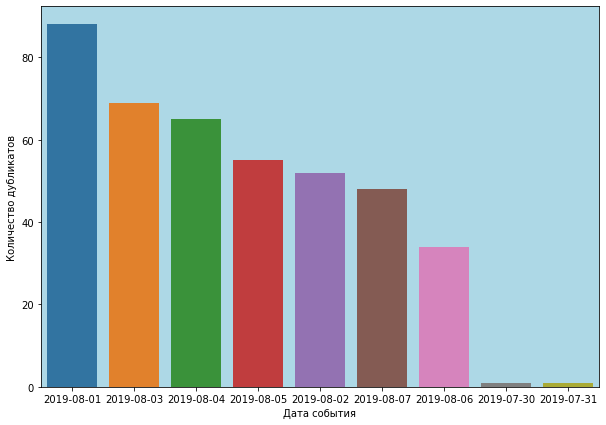

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=uplicateRows, x="event_date", y ='user_id' ,ci = False)

plt.xlabel("Дата события")
plt.ylabel("Количество дубликатов")
ax.set_facecolor('lightblue')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8 ],['2019-08-01','2019-08-03','2019-08-04','2019-08-05', '2019-08-02', '2019-08-07',\
'2019-08-06', '2019-07-30', '2019-07-31']);

Больше всего дубликатов у нас за 30 число, данные которые мы как раз очистим ниже. Не думаю что стоит убирать дубликаты, потому что они у нас достаточно одинаково распределены и если мы удалим например дубликаты за 6 число, потому что там больший показатель дубликатов, то нам придется также удалить и все остальные дубликаты, с других чисел. Иначе возникнет перекос по дубликатам , что может исказить данные дальнейших исследований. Дубликаты при посещении страниц могли возникнуть по разным причинам, одна из возможных: некорректная прогрузка сайта, когда данные о посещениях перезаписывались.

Посчитать количество событий в логе.

In [11]:
data_log.groupby('event_name').agg({'event_date':'count'}).reset_index()

,event_name,event_date
0,CartScreenAppear,42731
1,MainScreenAppear,119205
2,OffersScreenAppear,46825
3,PaymentScreenSuccessful,34313
4,Tutorial,1052


Посчитать количество уникальных пользователей в логе.

In [12]:
number_of_users = data_log.groupby('event_name').agg({'user_id':'nunique'}).reset_index()
total_number_of_users = data_log['user_id'].nunique()
total_amount_of_data = data_log['user_id'].count()

print("Общее количество уникальных пользователей перед удалением аномальных пользователей:",total_number_of_users,
      '\n',
      "Общее количество данных перед удалением аномальных пользователей:",total_amount_of_data) 
display(number_of_users)

Общее количество уникальных пользователей перед удалением аномальных пользователей: 7551 
 Общее количество данных перед удалением аномальных пользователей: 244126


,event_name,user_id
0,CartScreenAppear,3749
1,MainScreenAppear,7439
2,OffersScreenAppear,4613
3,PaymentScreenSuccessful,3547
4,Tutorial,847


Посчитать сколько в среднем событий приходится на одного пользователя.

In [13]:
print('Среднее количество событий на пользователя равно: ',\
      int(np.round(data_log.groupby('user_id').agg({'event_name':'count'}).mean())))
data_log.groupby('user_id').agg({'event_name':'count'}).reset_index().sort_values(by = 'event_name', ascending = False).head(2289)

Среднее количество событий на пользователя равно:  32


,user_id,event_name
5116,6304868067479728361,2308
147,197027893265565660,2003
3714,4623191541214045580,1771
5590,6932517045703054087,1448
1391,1754140665440434215,1222
...,...,...
5656,7003124882657797758,33
4040,4993960573648336100,33
5046,6224840966394928541,33
6110,7525415361824974551,33


In [14]:
sum_event = data_log.groupby('user_id').agg({'event_name':'count'}).reset_index()
sum_event['event_name'].count()

7551

Определить минимальную и максимальную дату времени эксперимента до очистки данных.

In [15]:
print("Первая дата событий:",data_log['event_date'].min(),"\n","Последняя дата событий:",data_log['event_date'].max())

Первая дата событий: 2019-07-25 00:00:00 
 Последняя дата событий: 2019-08-07 00:00:00


Первая дата событий это 25  июля.Поэтому чтобы определить аномальные зоны пользователей, которые могли прийти в приложение раньше, чем начался эксперимент , мы срежем первые дни эксперимента и посмотрим на активность пользователей в эти дни, и если окажется что там менее активные зоны, то скорее всего, они не относятся к эксперименту и данные этих пользователей могут исказить резуьтаты исследования, которое мы проводим.

Сделать срез для проверки аномальных зон.

In [16]:
df = data_log[(data_log['event_date']> "2019-07-25") & (data_log['event_date']<= "2019-08-02")]
df

,event_name,user_id,event_date,exp_id,date
9,MainScreenAppear,5407636962369102641,2019-07-26,246,2019-07-26 03:35:12
10,MainScreenAppear,948465712512390382,2019-07-26,247,2019-07-26 05:33:34
11,MainScreenAppear,2547684315586332355,2019-07-26,248,2019-07-26 06:50:26
12,MainScreenAppear,8885295911290764495,2019-07-26,248,2019-07-26 06:54:45
13,MainScreenAppear,2140904690380565988,2019-07-26,247,2019-07-26 07:22:12
...,...,...,...,...,...
74658,MainScreenAppear,8652127031019540255,2019-08-02,247,2019-08-02 23:59:27
74659,MainScreenAppear,813201901330563996,2019-08-02,247,2019-08-02 23:59:31
74660,OffersScreenAppear,8652127031019540255,2019-08-02,247,2019-08-02 23:59:33
74661,OffersScreenAppear,813201901330563996,2019-08-02,247,2019-08-02 23:59:35


Сделать сводную таблицу для проверки аномальных зон.

In [17]:
abnormal_users_pivot_table = (
    df.pivot_table(index='event_date', values='user_id', aggfunc = 'nunique')
    .reset_index()
)
abnormal_users_pivot_table

,event_date,user_id
0,2019-07-26,22
1,2019-07-27,39
2,2019-07-28,69
3,2019-07-29,135
4,2019-07-30,296
5,2019-07-31,924
6,2019-08-01,3703
7,2019-08-02,3647


Построить график, отображающий аномальные зоны.

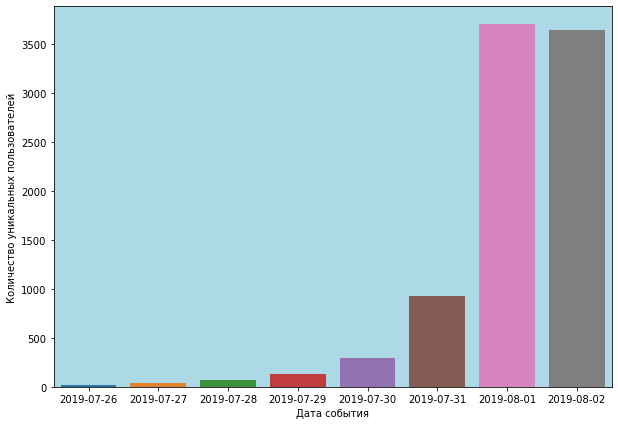

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=abnormal_users_pivot_table, x="event_date", y="user_id")
ax.set_xticklabels(abnormal_users_pivot_table.event_date.dt.date)
plt.xlabel("Дата события")
plt.ylabel("Количество уникальных пользователей")
ax.set_facecolor('lightblue');

Можно сделать вывод, что количество пользователей начинает расти только 1 числа 8 месяца, а это значит, что информация за предыдущие дни может исказить достоверность исследования, поэтому нам стоит ее исключить из анализа.

Удалить аномальных пользователей.

In [68]:
data_log = data_log.loc[data_log['event_date'] >'2019-07-31']
data_log

,event_name,user_id,event_date,exp_id,date
2828,Tutorial,3737462046622621720,2019-08-01,A,2019-08-01 00:07:28
2829,MainScreenAppear,3737462046622621720,2019-08-01,A,2019-08-01 00:08:00
2830,MainScreenAppear,3737462046622621720,2019-08-01,A,2019-08-01 00:08:55
2831,OffersScreenAppear,3737462046622621720,2019-08-01,A,2019-08-01 00:08:58
2832,MainScreenAppear,1433840883824088890,2019-08-01,B,2019-08-01 00:08:59
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07,B,2019-08-07 21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07,A,2019-08-07 21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07,A,2019-08-07 21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07,A,2019-08-07 21:14:58


Посчитать количество уникальных пользователей после очистки данных.

In [69]:
number_of_users_after_cleaning = data_log.groupby('event_name').agg({'user_id':'nunique'}).reset_index()
total_number_of_users_after_cleaning = data_log['user_id'].nunique()
total_amount_of_data_after = data_log['user_id'].count()
display("было:",number_of_users,'стало:',number_of_users_after_cleaning)
print("Общее количество уникальных пользователей после удаления аномальных пользователей:",total_number_of_users_after_cleaning,
      '\n',
     "Общее количество уникальных пользователей до удаления аномальных пользователей:",total_number_of_users,
      '\n',
      "Общее число удаленных пользователей: ", total_number_of_users - total_number_of_users_after_cleaning,
      '\n',
      "Общее количество данных перед удалением аномальных пользователей:",total_amount_of_data,
      '\n',
      "Общее количество данных после удаления аномальных пользователей:",total_amount_of_data_after,
      '\n',
      'Общее число удаленных данных:', total_amount_of_data - total_amount_of_data_after
     )


'было:'

,event_name,user_id
0,CartScreenAppear,3749
1,MainScreenAppear,7439
2,OffersScreenAppear,4613
3,PaymentScreenSuccessful,3547
4,Tutorial,847


'стало:'

,event_name,user_id
0,CartScreenAppear,3734
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Общее количество уникальных пользователей после удаления аномальных пользователей: 7534 
 Общее количество уникальных пользователей до удаления аномальных пользователей: 7551 
 Общее число удаленных пользователей:  17 
 Общее количество данных перед удалением аномальных пользователей: 244126 
 Общее количество данных после удаления аномальных пользователей: 241298 
 Общее число удаленных данных: 2828


Общая потеря среди пользователей составила : 17 пользователей.

Определить границы эксперимента после очистки даннных.

In [21]:
print("Первая дата событий:",data_log['event_date'].min(),"\n","Последняя дата событий:",data_log['event_date'].max())

Первая дата событий: 2019-08-01 00:00:00 
 Последняя дата событий: 2019-08-07 00:00:00


Выходит, что настоящий период , который мы исследуем в нашем эксперименте - это период с 1 числа восьмого месяца по 7 число того же месяца, то есть 1 неделя.

Проверить наличие всех трех групп для дальнейшего анализа.

In [22]:
data_log['exp_id'].unique()

array([246, 247, 248], dtype=int64)

In [70]:
data_log.groupby('event_name')['user_id'].count().sort_values(ascending = False).reset_index()

,event_name,user_id
0,MainScreenAppear,117431
1,OffersScreenAppear,46350
2,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


Чаще других встречается событие "MainScreenAppear", оно в 117 раз встречается чаще чем последнее по популярности событие, а именно: "Tutorial".

Подсчитать долю пользователей для каждого типа события.

In [24]:
number_in_logs = data_log.groupby('event_name').agg({'user_id':'nunique'}).\
sort_values(by = 'user_id' , ascending = False).reset_index()
the_number_of_total_logs = data_log['user_id'].nunique()
number_in_logs['user_id'] = number_in_logs['user_id'] / the_number_of_total_logs * 100 
number_in_logs

,event_name,user_id
0,MainScreenAppear,98.473586
1,OffersScreenAppear,60.963632
2,CartScreenAppear,49.561986
3,PaymentScreenSuccessful,46.973719
4,Tutorial,11.149456


Заменить названия групп тестирования.

In [25]:
data_log = data_log.replace({'exp_id' : { 246: 'A', 247 : 'B', 248 : 'C'}})

### Сделать воронку для групп тестирования.

Подсчитать общее количество уникальных пользователей для каждой группы.

In [26]:
group_a = data_log.loc[data_log['exp_id'] == 'A']['user_id'].nunique()
group_b = data_log.loc[data_log['exp_id'] == 'B']['user_id'].nunique()
group_c = data_log.loc[data_log['exp_id'] == 'C']['user_id'].nunique()


Подсчитать количество уникальных пользователей по каждому логу для группы А.

In [27]:
a =  data_log.loc[data_log['exp_id'] == 'A'].groupby(['event_name']).agg({ 'user_id':'nunique'}).reset_index().\
sort_values(by = 'user_id', ascending = False)

Подсчитать долю каждого лога от общего количества пользователей в логе для группы А.

In [28]:
a['user_id'] = a['user_id'] / group_a * 100

Добавить название группы в отдельный столбец.

In [29]:
a['group'] = 'A'

Подсчитать количество уникальных пользователей по каждому логу для группы В.

In [30]:
b = data_log.loc[data_log['exp_id'] == 'B'].groupby(['event_name']).agg({ 'user_id':'nunique'}).reset_index().\
sort_values(by = 'user_id', ascending = False)

Подсчитать долю каждого лога от общего количества пользователей в логе для группы В.

In [31]:
b['user_id'] = b['user_id'] / group_b * 100

Добавить название группы в отдельный столбец.

In [32]:
b['group'] = 'B'

Подсчитать количество уникальных пользователей по каждому логу для группы С.

In [33]:
c = data_log.loc[data_log['exp_id'] == 'C'].groupby(['event_name']).agg({ 'user_id':'nunique'}).reset_index().\
sort_values(by = 'user_id', ascending = False)

Подсчитать долю каждого лога от общего количества пользователей в логе для группы С.

In [34]:
c['user_id'] = c['user_id'] / group_c * 100

Добавить название группы в отдельный столбец.

In [35]:
c['group'] = 'C'

"Склеить" таблицы.

In [36]:
abc = pd.concat([a, b, c], ignore_index=True, sort=False)

Закрепить нужные значения за воронкой.

In [37]:
abc=abc[abc['event_name']!='Tutorial']
abc

,event_name,user_id,group
0,MainScreenAppear,98.631240,A
1,OffersScreenAppear,62.077295,A
2,CartScreenAppear,50.966184,A
3,PaymentScreenSuccessful,48.309179,A
5,MainScreenAppear,98.527656,B
6,OffersScreenAppear,60.485476,B
7,CartScreenAppear,49.263828,B
8,PaymentScreenSuccessful,46.080382,B
10,MainScreenAppear,98.265668,C
11,OffersScreenAppear,60.346866,C


По получившимся данным можно построить воронку событий: MainScreenAppear=>OffersScreenAppear=>CartScreenAppear=>PaymentScreenSuccessful

Tutorial не будет относиться к воронке, потому что это необязательный шаг к прохождению от главной страницы до страницы с оплатой. Этот шаг проходится по желанию и отдельно.

Построить график распределения пользователей по логам для каждой группы.

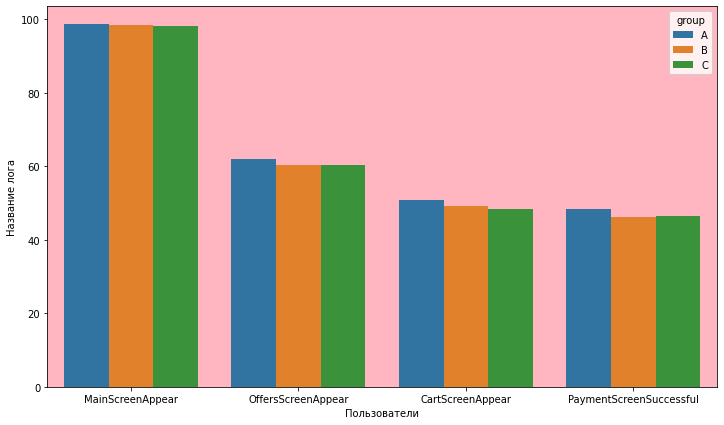

In [54]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=abc, x="event_name", y="user_id", hue = 'group')
plt.xlabel("Пользователи")
plt.ylabel("Название лога")
ax.set_facecolor('lightpink');

Как мы можем увидеть, у нас равномерное распределение трех групп по существующим логам . Проблем при распределении не обнаружено: каждая группа в одинаковых пропорциях проходит все страницы сайта. Самая высокая активность установлена на главной странице, что также доказывает правильность данных для дальнейшего анализа.
Самая большая потеря пользователей происходит при переходе с главной страницы на страницу предложений. 


In [39]:
fraction_a = int(a.loc[a['event_name']=='PaymentScreenSuccessful']['user_id'])\
/ int(a.loc[a['event_name']=='MainScreenAppear']['user_id']) * 100
fraction_b =  int(b.loc[b['event_name']=='PaymentScreenSuccessful']['user_id'])\
/ int(b.loc[b['event_name']=='MainScreenAppear']['user_id']) * 100
fraction_c = int(c.loc[c['event_name']=='PaymentScreenSuccessful']['user_id'])\
/ int(c.loc[c['event_name']=='MainScreenAppear']['user_id']) * 100
print('Доля пользователей для группы А равна :',fraction_a,'\n','Доля пользователей для группы В равна :', fraction_b,'\n',
      'Доля пользователей для группы C равна :', fraction_c)

Доля пользователей для группы А равна : 48.97959183673469 
 Доля пользователей для группы В равна : 46.93877551020408 
 Доля пользователей для группы C равна : 46.93877551020408


Доля пользователей , которая доходит с главной страницы до оплаты это : 48,97 процентов для группы А и 46,94 для групп B и С.

In [40]:
lost_users_for_group_a = int(a.loc[a['event_name']=='MainScreenAppear']['user_id'])\
- int(a.loc[a['event_name']=='OffersScreenAppear']['user_id'])
lost_users_for_group_b = int(b.loc[b['event_name']=='MainScreenAppear']['user_id'])\
- int(b.loc[b['event_name']=='OffersScreenAppear']['user_id'])
lost_users_for_group_c = int(c.loc[c['event_name']=='MainScreenAppear']['user_id'])\
- int(c.loc[c['event_name']=='OffersScreenAppear']['user_id'])
print('Доля потерянных пользователей после посещения главной страницы, перед переходом на предложение для группы А составила:'
      ,lost_users_for_group_a, '\n', 'Доля потерянных пользователей после посещения '
      'главной страницы, перед переходом на предложение для группы B составила:', lost_users_for_group_b, '\n',
     'Доля потерянных пользователей после посещения главной страницы, перед переходом на предложение для группы C составила:',
     lost_users_for_group_c)

Доля потерянных пользователей после посещения главной страницы, перед переходом на предложение для группы А составила: 36 
 Доля потерянных пользователей после посещения главной страницы, перед переходом на предложение для группы B составила: 38 
 Доля потерянных пользователей после посещения главной страницы, перед переходом на предложение для группы C составила: 38


Если подсчитать какая потеря происходит, то это: 36 % для группы А; 38 процентов для группы B и столько же сколько для группы B для группы C. 

Подсчитать отношение предыдущей группы к следующей по количеству пользователей, чтобы определить разницу в прохождении между группами.

In [73]:
new_b = b.copy()
b['user_id'] = b['user_id'] / a['user_id'] * 100
b['group'] = 'BA'
c['user_id'] = c['user_id'] / new_b['user_id'] * 100
c['group'] = 'CB'
a_b_c = pd.concat([b, c], ignore_index=True, sort=False)
a_b_c

,event_name,user_id,group
0,MainScreenAppear,104.111854,BA
1,OffersScreenAppear,407.305215,BA
2,CartScreenAppear,730.129170,BA
3,PaymentScreenSuccessful,846.052772,BA
4,Tutorial,71782.921422,BA
5,MainScreenAppear,95.996669,CB
6,OffersScreenAppear,25.801623,CB
7,CartScreenAppear,14.426624,CB
8,PaymentScreenSuccessful,13.123301,CB
9,Tutorial,0.134359,CB


Мы нашли процент пользователей от группы А в группе В для каждого лога и процент пользователей от группы В в группе С для каждого лога.

Построить график прохождения пользователей по группам.

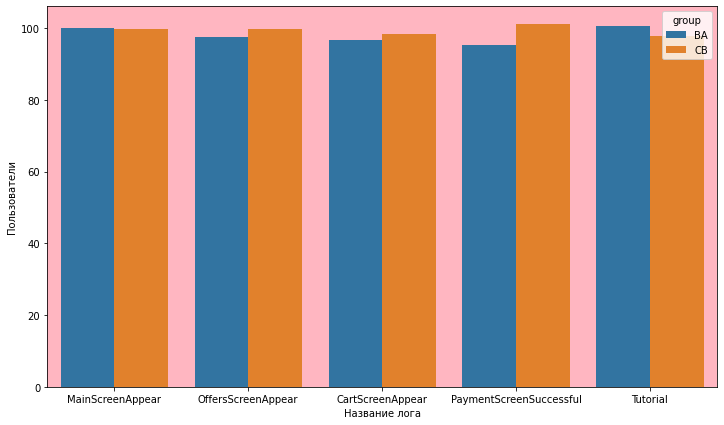

In [55]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=a_b_c, x="event_name", y="user_id", hue = 'group')
plt.xlabel("Название лога")
plt.ylabel("Пользователи")
ax.set_facecolor('lightpink');

Как мы можем увидеть, пользователи примерно одинаково движутся по страницам от группы к группе. Различия в небольшом изменении лидерства по активности, различном на разных этапах равномерно для каждого перехода между группами.

#### Построить сводную таблицу количества уникальных пользователей по группам для каждого лога и общее количество для каждого лога.

In [57]:
data_log_h =  data_log.copy()
data_log_h1 = data_log_h[data_log_h['exp_id'] == 'A'].groupby('event_name').agg({'user_id':'nunique'})\
.reset_index().rename(columns={'user_id':'A'})
data_log_h2 = data_log_h[data_log_h['exp_id'] == 'B'].groupby('event_name').agg({'user_id':'nunique'}).\
reset_index().rename(columns={'user_id':'B'})
data_log_h3 = data_log[data_log['exp_id'] == 'C'].groupby('event_name').agg({'user_id':'nunique'}).\
reset_index().rename(columns={'user_id':'C'})



result = pd.merge(data_log_h1, data_log_h2, how="left", on='event_name')
result = pd.merge(result,data_log_h3, how ="left", on ='event_name' )

result['count_a'] =  data_log_h[data_log_h['exp_id'] == 'A']['user_id'].nunique()
result['count_b'] = data_log_h[data_log_h['exp_id'] == 'B']['user_id'].nunique()
result['count_c'] = data_log_h[data_log_h['exp_id'] == 'C']['user_id'].nunique()

result['A + B'] = result['A'] + result['B']
result['count_A + count_B'] = result['count_a'] + result['count_b']

result

,event_name,A,B,C,count_a,count_b,count_c,A + B,count_A + count_B
0,CartScreenAppear,1266,1238,1230,2484,2513,2537,2504,4997
1,MainScreenAppear,2450,2476,2493,2484,2513,2537,4926,4997
2,OffersScreenAppear,1542,1520,1531,2484,2513,2537,3062,4997
3,PaymentScreenSuccessful,1200,1158,1181,2484,2513,2537,2358,4997
4,Tutorial,278,283,279,2484,2513,2537,561,4997


Добавить тест для проверки разницы статистических критериев.

In [59]:
def test_stat(successes,trials):
    alpha = .05 # критический уровень статистической значимости
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

Написать метод для обработки информации для теста.

In [74]:
def preparing_data_for_the_test(the_first_private, the_second_private, the_first_general, the_second_general):
    p1 = [0,0]
    p2 = [0,0]
    for letter in result['event_name']:
        b = result[result['event_name']== letter]
        p1[0] = b[the_first_private].iloc[0]
        p1[1] = b[the_second_private].iloc[0]
        p2[0] = b[the_first_general].iloc[0]
        p2[1] = b[the_second_general].iloc[0]
        test_stat(p1,p2)

Уровень значимости для проверки гипотез α=0,05

Гипотеза H0: конверсии пользователей группы А и группы B совершивших целевое событие равны

Гипотеза H1: конверсии пользователей группы А и группы B совершивших целевое событие не равны 

Провести тесты для проверки гипотезы.

In [61]:
preparing_data_for_the_test('A','B', 'count_a','count_b')

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимые отличия не обнаружены, значит мы можем предположить, что разницы между результатами показателей групп нет.

Гипотеза H0: конверсии пользователей группы В и группы С совершивших целевое событие равны

Гипотеза H1: конверсии пользователей группы В и группы С совершивших целевое событие не равны 

In [47]:
preparing_data_for_the_test('B','C', 'count_b','count_c')

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимые отличия не обнаружены, значит мы можем предположить, что разницы между результатами показателей групп нет.

Гипотеза H0: конверсии пользователей группы А и группы C совершивших целевое событие равны

Гипотеза H1: конверсии пользователей группы А и группы C совершивших целевое событие не равны 

In [48]:
preparing_data_for_the_test('A','C', 'count_a','count_c')

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимые отличия не обнаружены, значит мы можем предположить, что разницы между результатами показателей групп нет.

Гипотеза H0: конверсии пользователей группы А+B и группы C совершивших целевое событие равны

Гипотеза H1: конверсии пользователей группы А+B и группы C совершивших целевое событие не равны 

In [49]:
preparing_data_for_the_test('A + B','C', 'count_A + count_B','count_c')

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимые отличия не обнаружены, значит мы можем предположить, что разницы между результатами показателей групп нет.

Установить самое популярное событие.

In [63]:
the_most_popular_event = data_log.groupby('event_name').agg({'user_id':'nunique'}).\
sort_values(by = 'user_id', ascending = False).reset_index()
the_most_popular_event

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Посчитать количество совершивших переход на главную страницу среди групп.

In [65]:
transitions_to_the_main_page = data_log[data_log['event_name'] == 'MainScreenAppear'].\
groupby('exp_id').agg({'user_id':'nunique'}).reset_index()
transitions_to_the_main_page

,exp_id,user_id
0,A,2450
1,B,2476
2,C,2493


Посчитать долю совершивших переход на главную страницу от всех пользователей совершивших переход на главную страницу по группам.

In [66]:
transitions_to_the_main_page['percent'] = transitions_to_the_main_page['user_id'] / the_most_popular_event['user_id']
transitions_to_the_main_page

,exp_id,user_id,percent
0,A,2450,0.330233
1,B,2476,0.539081
2,C,2493,0.667649


Больше всего переходов на главную страницу от всех пользователей совершивших это действие было выявлено у группы С. Этот факт нельзя было бы исключить из расмотрения, однако , проведенный нами тест выше показывает, что статистически можно доказать только отсутствие различий в показателях между группами.

Установить количество пользователей в каждой группе.

In [67]:
data_log.groupby('exp_id').agg({'user_id':'nunique'})

,user_id
exp_id,
A,2484
B,2513
C,2537


Количество пользователей в каждой группе можно назвать правильными распределением,  над которым воможно проводить тесты, которые были проведены выше и установление факта отсутствия отличий между группами не будет интерпретироваться не правильно, потому что распределение по группам доказывает что результаты эксперимента зависят от реальных показателей, которые не отличаются количественно.

## Написать вывод.

Нами был выбран уровень значимости 0.05, в данном случае этот уровень является более чем оптимальным, потому что большинство результатов теста превышает статистический порог в 0,10 , который был также предложен как один из возможных статистических критериев. Мы провели 20 проверок гипотез, по 5 на каждую пару групп + проверка суммарных показателей двух экспериментальных групп с контрольной. По итогам тестирования сделаны выводы, что изменения предложенные в данном случае являются не оптимальным решением за отсутствием у него положительных показателей в сторону минимальной статистической значимости, которая не была достигнута ни в одном из проведенных нами тестов. Стоит прекратить это исследование и изучить более оптимальный способ повышения продаж и совершения покупок на странице оплаты , до которой дошла меньшая часть пользователей группы С, чем группы А (для группы А количество пользователей , дошевших до оплаты: 48 процентов; для группы C количество пользователей , дошедших до оплаты: 46 процентов), что доказывает несостоятельность показателей по количеству проведенных оплат для группы С, а значит, эксперимент можно считать завершенным а изменения , связанные с изменениями в контрольной группе - несостоявшимися.